In [1]:
%matplotlib notebook

import os
import time
import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.utils.data as td 
import torchvision as tv
from torch.autograd import Variable
from PIL import Image
import matplotlib.pyplot as plt 
import nntools as nt

from itertools import chain
from DnCNN import DnCNN

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
print(device)

cuda


In [3]:
class StyleTransDataset(td.Dataset):

    def __init__(self, content_root_dir, style_root_dir,
                 content_category, style_category,
                 image_size=(150, 150), sigma=30): 
        super(StyleTransDataset, self).__init__()
        self.content_cat = content_category
        self.style_cat = style_category
        self.image_size = image_size
        self.sigma = sigma
        
        self.content_dir = os.path.join(content_root_dir, content_category) 
        self.style_dir = os.path.join(style_root_dir, style_category) 
        self.content_files = os.listdir(self.content_dir)
        self.style_files = os.listdir(self.style_dir)
        
    def __len__(self):
        return len(self.content_files) #min(self.content_num(), self.style_num())
    
    def content_num(self):
        return len(self.content_files)
    
    def style_num(self):
        return len(self.style_files)
    
    def __repr__(self):
        return (f"StyleTransDataset(category: {self.content_cat}"
                f", image_size={self.image_size}, sigma={self.sigma})")

    def __getitem__(self, idx):
        content_path = os.path.join(self.content_dir, self.content_files[idx]) 
        content = Image.open(content_path).convert('RGB')
        
#         style_path = os.path.join(self.style_dir, self.style_files[idx]) 
#         style = Image.open(style_path).convert('RGB')
        
        return self.trans(content) #, self.trans(style)
    
    def trans(self, img):
        i = np.random.randint(img.size[0] - self.image_size[0]) 
        j = np.random.randint(img.size[1] - self.image_size[1]) 

        img = img.crop([i, j , i + self.image_size[0], j + 
                            self.image_size[1]]) 
        
        transform = tv.transforms.Compose([
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
            ])
        
        img = transform(img)
        return img

**Style**:
Abstract_Expressionism	    Minimalism
Action_painting		    Naive_Art_Primitivism
Analytical_Cubism	    New_Realism
Art_Nouveau_Modern	    Northern_Renaissance
Baroque			    Pointillism
Color_Field_Painting	    Pop_Art
Contemporary_Realism	    Post_Impressionism
Cubism			    Realism
Early_Renaissance	    Rococo
Expressionism		    Romanticism
Fauvism			    Symbolism
High_Renaissance	    Synthetic_Cubism
Impressionism		    Ukiyo_e
Mannerism_Late_Renaissance

**Content:**
city   forest  licenses  ocean  road
field  lake    mountain

In [4]:
content_root_dir = "//datasets/ee285f-public/flickr_landscape/"
style_root_dir = "/datasets/ee285f-public/wikiart/wikiart/"
train_set = StyleTransDataset(content_root_dir, style_root_dir, "city", "Art_Nouveau_Modern")

In [5]:
style_ref = Image.open("./starry_night.jpg").convert('RGB')
transform = tv.transforms.Compose([
            tv.transforms.Resize((150, 150)),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
            ])
style_ref = transform(style_ref)

content_ref = Image.open("./house.jpg").convert('RGB')
transform = tv.transforms.Compose([
            tv.transforms.Resize((150, 150)),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
            ])
content_ref = transform(content_ref)

In [6]:
test = train_set[8]

In [7]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1]) 
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1 
    h = ax.imshow(image) 
    ax.axis('off') 
    return h

In [8]:
class Generator(DnCNN):
    def __init__(self, D, C=64):
        super(Generator, self).__init__(D)
        
    def criterion(self, y, d):
        return nn.MSELoss()(y, d)
        
class Discriminator(DnCNN):
    def __init__(self, D, C=64):
        super(Discriminator, self).__init__(D)
        
        self.cnn = nn.Sequential()
        dims = [3, 16, 64, 256, 256]
        for i in range(len(dims) - 1):
            self.cnn.add_module(f"conv2d{i}", nn.Conv2d(dims[i], dims[i + 1], 3, padding = 1))
            self.cnn.add_module(f"instNorm{i}", nn.InstanceNorm2d(dims[i + 1]))
            self.cnn.add_module(f"relu{i}", nn.LeakyReLU(0.2, True))
        
        self.cnn.add_module("cov2dFL", nn.Conv2d(256, 1, 3, padding=1, bias=False))
        
    def forward(self, x):
        h = self.cnn(x)
        h = h.view(h.size(0), -1)
        return h
    
    def criterion(self, y, d):
        return nn.L1Loss()(y, d)

In [9]:
class CGANTrainer():

    def __init__(self, gen2s, gen2c, dis_c, dis_s, device):
        self.device = device
        
        self.gen2s = gen2s
        self.gen2c = gen2c
        self.dis_c = dis_c
        self.dis_s = dis_s
        
        self.lr = 1e-3
        self.adam_gen = torch.optim.Adam(chain(gen2s.parameters(), gen2c.parameters()), lr=self.lr, betas=(0.5,0.999))
        self.adam_dis_c = torch.optim.Adam(dis_c.parameters(), lr=self.lr, betas=(0.5,0.999))
        self.adam_dis_s = torch.optim.Adam(dis_s.parameters(), lr=self.lr, betas=(0.5,0.999))
        
        self.l1Loss = nn.L1Loss().to(self.device)
        self.l2Loss = nn.MSELoss().to(self.device)
        
    def forward(self, content, style):
        self.content = content
        self.style = style
        self.S_c = self.gen2s(content)
        self.C_S_c = self.gen2c(self.S_c)
        self.C_s = self.gen2c(style)
        self.S_C_s = self.gen2s(self.C_s)
        
    def train_generator(self):  
        self.adam_gen.zero_grad()

        totalLoss = 0

        # get identity loss for same input same output            
#         gen_style = self.gen2s(self.style)
#         totalLoss += self.l1Loss(gen_style, self.style)
        
#         gen_content = self.gen2c(self.content)
#         totalLoss += self.l1Loss(gen_content, self.content)

        # get Discriminator Loss
        disS= self.dis_s(self.S_c)
        real_var = Variable(torch.cuda.FloatTensor(disS.shape).fill_(1.0),
                            requires_grad = False)
        totalLoss += self.l2Loss(disS, real_var)
        
        disC = self.dis_c(self.C_s)
        real_var = Variable(torch.cuda.FloatTensor(disC.shape).fill_(1.0),
                            requires_grad = False)
        totalLoss += self.l2Loss(disC, real_var)

        # get Cycle GAN Loss
        totalLoss += self.l1Loss(self.C_S_c, self.content)
        totalLoss += self.l1Loss(self.S_C_s, self.style)

        # update generator
        totalLoss.backward()
        self.adam_gen.step()
        return totalLoss
    
    def train_discriminator(self, mode):
        """
        Train the discriminator. 
        mode == 0: input content, train the discriminator for style 
        mode == 1: input style, train the discriminator for content
        ref: real picture to distinguish from
        """

        assert (mode == 0 or mode == 1), "input must be 0(in: content) or 1(in: style)" 

        if mode == 0:
            # Train the discrimination for style
            # Input a content file, and generate a fake style
            
            adam_dis = self.adam_dis_s
            dis, gen, ori = self.dis_s, self.S_c, self.style #self.gen2s
        else:
            # Train the discrimination for content
            # Input a style file, and generate a fake content
            adam_dis = self.adam_dis_c
            dis, gen, ori = self.dis_c, self.C_s, self.content #self.gen2c
        
            
        adam_dis.zero_grad()   
        
        totalLoss = 0
        
        disReal = dis(ori)
        real_var = Variable(torch.cuda.FloatTensor(disReal.shape).fill_(1.0),
                            requires_grad = False)
        totalLoss += self.l2Loss(disReal, real_var)
        
        # get Discriminator Loss
        dis_fake = dis(gen.detach())
        fake_var = Variable(torch.cuda.FloatTensor(dis_fake.shape).fill_(0.0),
                            requires_grad = False)

        totalLoss += self.l2Loss(dis_fake, fake_var)
        
        # update discriminator
        totalLoss.backward()
        adam_dis.step()
        return totalLoss

In [10]:
class CGANexp(nt.Experiment):
    def __init__(self, cGANTrainer, train_set, output_dir, 
                 picNum = 100, batch_size=16, device = device,
                 perform_validation_during_training=False):  
        # Initialize
        self.history = []
        self.trainer = cGANTrainer
        self.device = device
        
        self.criterionIdt = torch.nn.L1Loss()
        self.criterionIdt = torch.nn.L1Loss()
        self.criterionIdt = torch.nn.L1Loss()
        
        self.picNum = picNum
        self.net = self.trainer.gen2c

        self.test_loader = td.DataLoader(train_set,
                  batch_size=4, shuffle=False, 
                  drop_last=True, pin_memory=True)
                
        self.toRecover = {
            'contentGenNet': self.trainer.gen2c,
            'styleGenNet': self.trainer.gen2s,
            'contentDisNet': self.trainer.dis_c,
            'styleDisNet': self.trainer.dis_s,
            'genAdam': self.trainer.adam_gen,
            'contentDisAdam': self.trainer.adam_dis_c,
            'styleDisAdam': self.trainer.adam_dis_s,
            'history': self.history
           }
        
        # Define checkpoint paths
        if output_dir is None:
            output_dir = 'experiment_{}'.format(time.time())
        os.makedirs(output_dir, exist_ok=True)
        self.checkpoint_path = os.path.join(output_dir, "checkpoint.pth.tar")
        self.config_path = os.path.join(output_dir, "config.txt")

        # Transfer all local arguments/variables into attributes
        locs = {k: v for k, v in locals().items() if k is not 'self'}
        self.__dict__.update(locs)

        # Load checkpoint and check compatibility
        if os.path.isfile(self.config_path):
            with open(self.config_path, 'r') as f:
                if f.read()[:-1] != repr(self):
                    raise ValueError(
                        "Cannot create this experiment: "
                        "I found a checkpoint conflicting with the current setting.")
            print("Done Load from Checkpoint!")
            self.load()
        else:
            self.save()
        
    def setting(self):
        """Returns the setting of the experiment."""
        return {'contentGenNet': self.trainer.gen2c,
                'TrainSet': self.train_set,
                'styleGenNet': self.trainer.gen2s,
                'contentDisNet': self.trainer.dis_c,
                'styleDisNet': self.trainer.dis_s,
                'genAdam': self.trainer.adam_gen,
                'contentDisAdam': self.trainer.adam_dis_c,
                'styleDisAdam': self.trainer.adam_dis_s,
                'TrainSet': self.train_set,
                'BatchSize': self.batch_size,
                'PerformValidationDuringTraining': self.perform_validation_during_training}

    def __repr__(self):
        """Pretty printer showing the setting of the experiment. This is what
        is displayed when doing ``print(experiment)``. This is also what is
        saved in the ``config.txt`` file.
        """
        string = ''
        for key, val in self.setting().items():
            string += '{}({})\n'.format(key, val)
        return string
    
    def state_dict(self):
        """Returns the current state of the experiment."""
        return {'contentGenNet': self.trainer.gen2c.state_dict(),
                'styleGenNet': self.trainer.gen2s.state_dict(),
                'contentDisNet': self.trainer.dis_c.state_dict(),
                'styleDisNet': self.trainer.dis_s.state_dict(),
                'genAdam': self.trainer.adam_gen.state_dict(),
                'contentDisAdam': self.trainer.adam_dis_c.state_dict(),
                'styleDisAdam': self.trainer.adam_dis_s.state_dict(),
                'history': self.history
               }
    
    
    def load_state_dict(self, checkpoint):
        """Loads the experiment from the input checkpoint."""
        for key, val in checkpoint.items():
            if key not in self.toRecover:
                raise AttributeError(f"Loading is Wrong! Key is {key}")
            if key == 'history':
                self.history = val
            else:
                self.toRecover[key].load_state_dict(val)
               
        nets = [self.trainer.gen2c, self.trainer.gen2s, 
                self.trainer.dis_c, self.trainer.dis_s]
        adams = [self.trainer.adam_gen, self.trainer.adam_gen,
                 self.trainer.adam_dis_c, self.trainer.adam_dis_s]
        
        for net, optimizer in zip(nets, adams):
            for state in optimizer.state.values():
                for k, v in state.items():
                    if isinstance(v, torch.Tensor):
                        state[k] = v.to(self.device)
                        
    def load(self):
        """Loads the experiment from the last checkpoint saved on disk."""
        checkpoint = torch.load(self.checkpoint_path,
                                map_location=self.device)
        self.load_state_dict(checkpoint)
        del checkpoint
        
    def save(self):
        """Saves the experiment on disk, i.e, create/update the last checkpoint."""
        torch.save(self.state_dict(), self.checkpoint_path)
        with open(self.config_path, 'w') as f:
            print(self, file=f)
        
    def run(self, num_epochs, plot=None):
        global style_ref
        
        start_epoch = self.epoch
        print("Start/Continue training from epoch {}".format(start_epoch))
        if plot is not None:
            plot(self)
                
        for epoch in range(start_epoch, num_epochs):
            s = time.time()
            i = 0
            gen_loss = []
            dis_c_loss = []
            dis_s_loss = []
            total_loss = []
            
            for content in self.test_loader:
                if i > self.picNum:
                    break
                content = content.to(self.device)
                style = style_ref[np.newaxis].to(self.device)
                
                self.trainer.forward(content, style)
                
                gen_loss.append(self.trainer.train_generator().item())
                dis_c_loss.append(self.trainer.train_discriminator(0).item())
                dis_s_loss.append(self.trainer.train_discriminator(1).item())
            
                i += 1
                
            self.history.append((np.mean(gen_loss+dis_c_loss+dis_s_loss), np.mean(gen_loss), np.mean(dis_c_loss+dis_s_loss)))
            print("Epoch {} (Time: {:.2f}s)".format(
                self.epoch, time.time() - s))
            self.save()
            if plot is not None:
                plot(self)

In [11]:
def plot(exp, fig, axes, content, style, visu_rate=2): 
    if exp.epoch % visu_rate != 0:
        return
    with torch.no_grad():
        transfered = exp.trainer.gen2s(content[np.newaxis].to(exp.trainer.gen2s.device))[0] 
    axes[0][0].clear()
    axes[0][1].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    myimshow(content, ax=axes[0][0]) 
    axes[0][0].set_title('Content image') 
    
    myimshow(style, ax=axes[0][1]) 
    axes[0][1].set_title('Style image')

    myimshow(transfered, ax=axes[1][0]) 
    axes[1][0].set_title('Transfered image')
    

#     axes[1][1].plot([exp.history[k][0].item() 
#                      for k in range(exp.epoch)],label="Total Loss")
    axes[1][1].plot([exp.history[k][1].item() 
                     for k in range(exp.epoch)],label="Gen Loss")
    axes[1][1].plot([exp.history[k][2].item()
                     for k in range(exp.epoch)],label="Dis Loss")
    
    axes[1][1].legend(loc='best')
    
    axes[1][1].set_xlabel("Epoch")
    axes[1][1].set_ylabel("Loss")
    
    plt.tight_layout() 
    fig.canvas.draw()

In [28]:
gen2s = Generator(6).to(device)
gen2c = Generator(6).to(device)
dis_c = Discriminator(6).to(device)
dis_s = Discriminator(6).to(device)

cycleGan_trainer = CGANTrainer(gen2s, gen2c, dis_c, dis_s, device)

In [29]:
cycleGAN_exp = CGANexp(cycleGan_trainer, train_set, output_dir="cycleGAN_ckpt", batch_size = 4, picNum = 20,
                     perform_validation_during_training=True)

Done Load from Checkpoint!


<IPython.core.display.Javascript object>


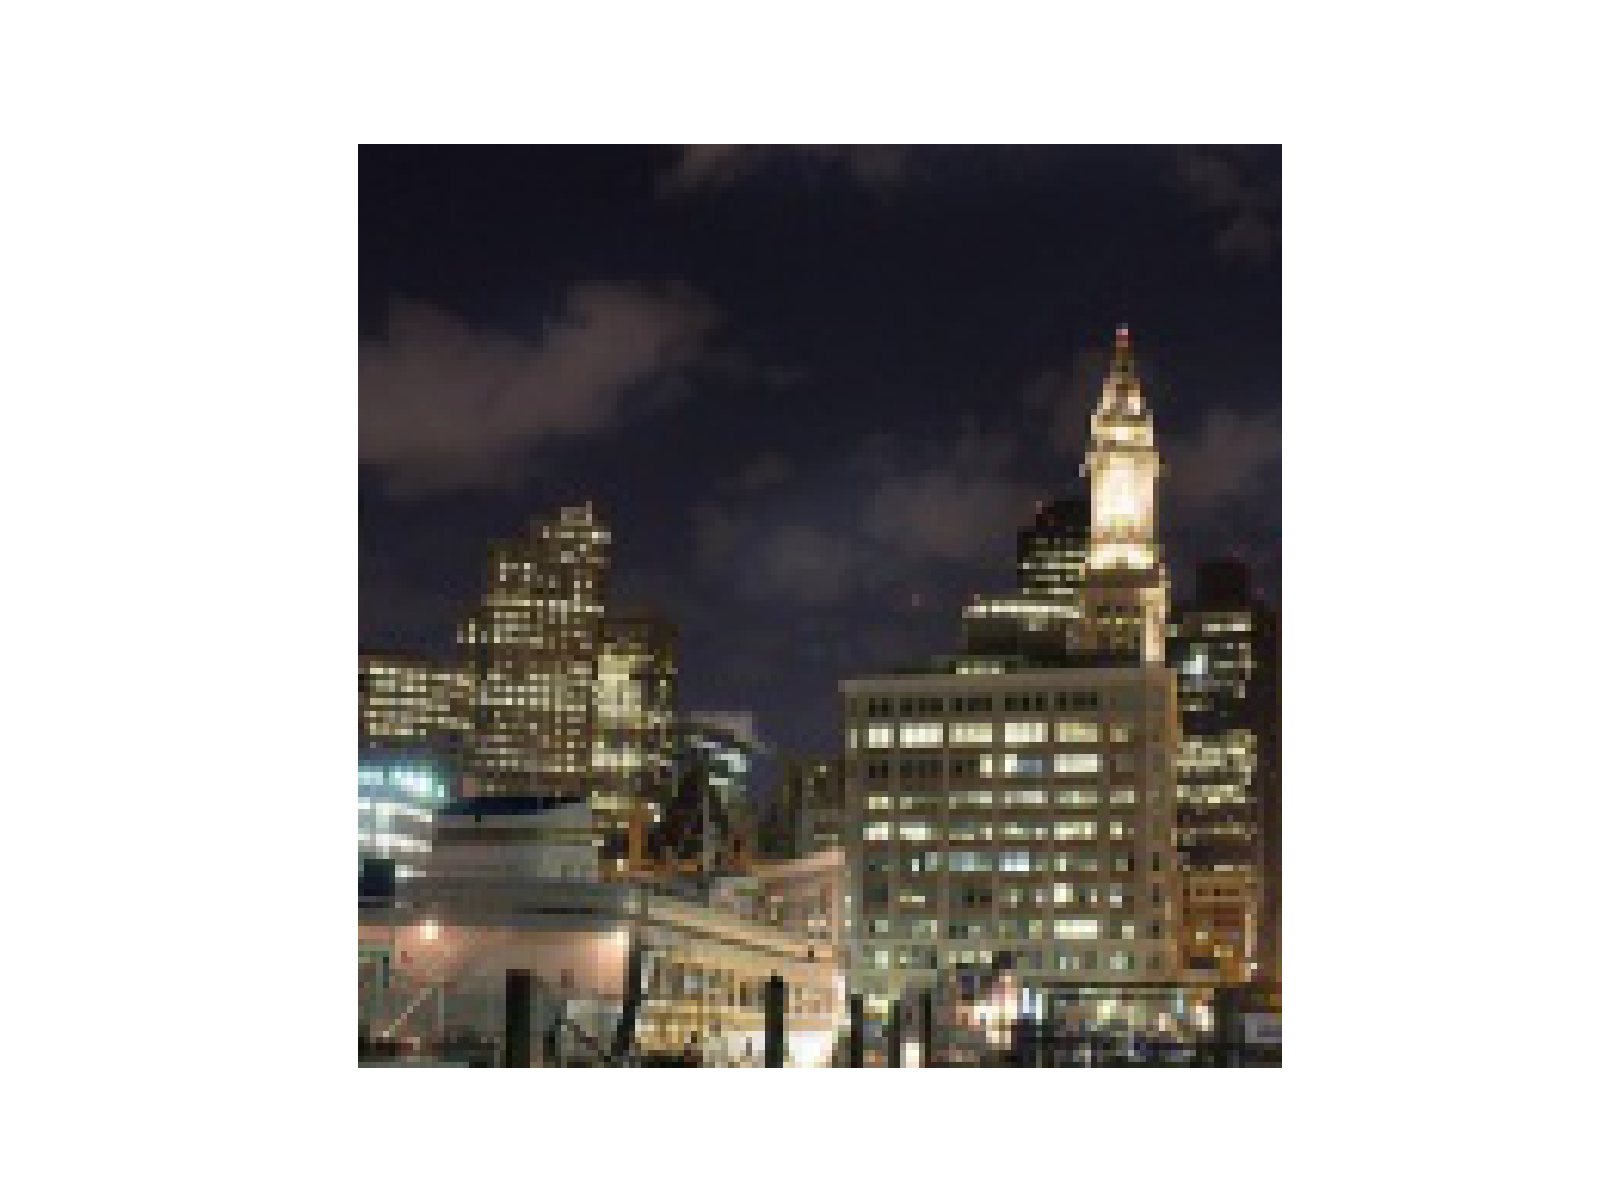

In [26]:
plt.figure()
myimshow(train_set[80].to(device))

with torch.no_grad():
    plt.figure()
    myimshow(cycleGAN_exp.trainer.gen2s(train_set[80][np.newaxis].to(device))[0])

<IPython.core.display.Javascript object>


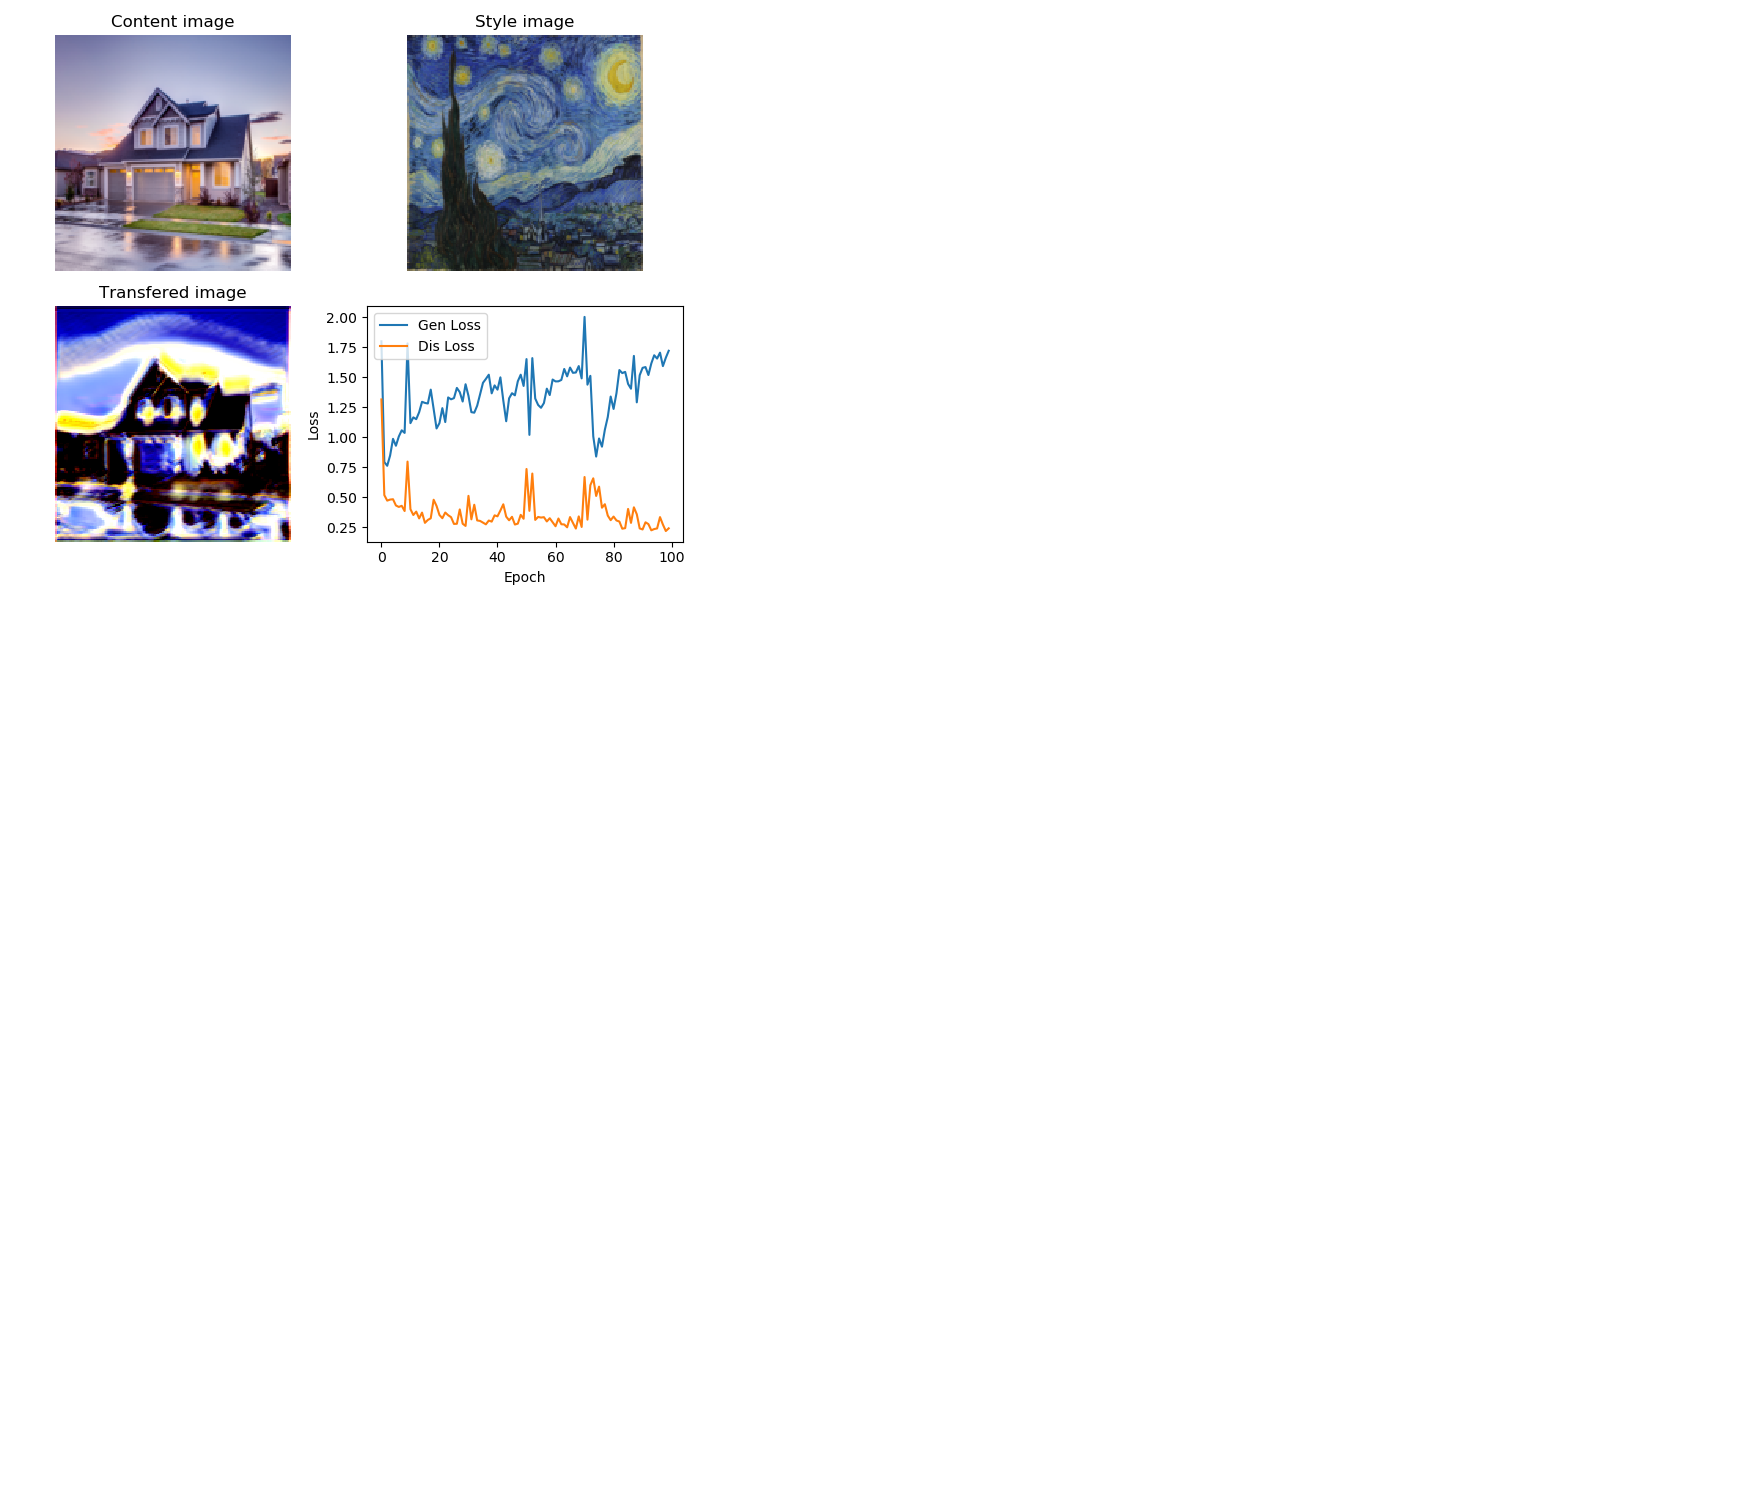

Start/Continue training from epoch 88
Epoch 89 (Time: 13.40s)
Epoch 90 (Time: 14.99s)
Epoch 91 (Time: 12.67s)
Epoch 92 (Time: 12.45s)
Epoch 93 (Time: 12.99s)
Epoch 94 (Time: 10.38s)
Epoch 95 (Time: 12.29s)
Epoch 96 (Time: 12.24s)
Epoch 97 (Time: 12.28s)
Epoch 98 (Time: 12.34s)
Epoch 99 (Time: 12.41s)
Epoch 100 (Time: 12.52s)
Epoch 101 (Time: 28.81s)


OSError: [Errno 28] No space left on device

In [30]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(7,6)) 
cycleGAN_exp.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes, 
                                                content=content_ref,
                                                style=style_ref))

In [ ]:
# gen2s_short = Generator(6).to(device)
# gen2c_short = Generator(6).to(device)
# dis_c_short = Discriminator().to(device)
# dis_s_short = Discriminator().to(device)

# gen2s_long = Generator(6).to(device)
# gen2c_long = Generator(6).to(device)
# dis_c_long = Discriminator().to(device)
# dis_s_long = Discriminator().to(device)

# cycleGan_trainer_group = CGANTrainer(gen2s_short, gen2c_short, dis_c_short, dis_s_short, device)
# cycleGan_trainer_long = CGANTrainer(gen2s_long, gen2c_long, dis_c_long, dis_s_long, device)